In [1]:
import math
import torch
from torch import nn
# from d2l import torch as d2l
import pandas as pd
import pickle
import numpy as np 

#### Check GPU availability

In [7]:
print("GPU availability: {}".format(torch.cuda.is_available()))
print("Number of GPU available: {}".format(torch.cuda.device_count()))

GPU availability: False
Number of GPU available: 0


In [9]:
# Request gpu even not available
# device = ...

def try_gpu(i=0):  #@save
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def try_all_gpus():  #@save
    """Return all available GPUs, or [cpu(),] if no GPU exists."""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

#### Heatmap

In [371]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap="Reds"):
	d2l.use_svg_display()
	num_rows, num_cols = matrices.shape[0], matrices.shape[1]
	fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False) # shape0, shape1 -- number of subplots

	for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)): # row_axes seperate out first dimension -- (1, 1, 10, 10) to (1, 10, 10)
		for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)): # ax seperate out second dimension -- (1, 10, 10) to (10, 10)
			pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
			if i == num_rows - 1:
				ax.set_xlabel(xlabel) # we may have (row, col) subplots -- we set xlabel at once at the bottom
			if j == 0:
				ax.set_ylabel(ylabel)
			if titles:
				ax.set_title(titles[j]) # a list a subtitles
	fig.colorbar(pcm, ax=axes, shrink=0.6)

#### Masked sequence

In [372]:
# X: (5, 10)
# value: [1, 5, 3, 6, 2] -- matching the rows 

def sequence_mask(X, valid_len, value=0):
	"""Mask irrelevant entries in sequences."""

	maxlen = X.size(1)
	mask = torch.arange((maxlen), dtype=torch.float32, device=X.device)[None, :] < valid_len[:, None]
	#print(mask)

	X[~mask] = value # set the masked elements to value 
	return X

#### Masked softmax operation

In [373]:
# X: (2, 3, 4) -- attention weights
# valid lens: specify how many elements to mask in each minibatch 
# valid lens (high dim): specify how to mask each minibatch 
def masked_softmax(X, valid_lens):
	"""Perform softmax operation by masking elements on the last axis"""

	if valid_lens == None:
		return nn.functional.softmax(X, dim=-1)
	else:
		shape = X.shape
		if valid_lens.dim() == 1:
			# 
			valid_lens = torch.repeat_interleave(valid_lens, shape[1])
		else:
			valid_lens = valid_lens.reshape(-1)
		X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)

		return nn.functional.softmax(X.reshape(shape), dim=-1)

#### Positional encoding

In [374]:
class PositionalEncoding(nn.Module):
	"""Position encoding X+P with dropout"""

	def __init__(self, num_hiddens, dropout, max_len=1000):
		super(PositionalEncoding, self).__init__()
		self.dropout = nn.Dropout(dropout)

		# create a single batch_size 1, long enough P, longer than sequence length
		self.P = torch.zeros((1, max_len, num_hiddens))
		X = torch.arange(max_len, dtype=torch.float32).reshape(-1, 1) / torch.pow(10000, torch.arange(0, num_hiddens, 2, dtype=torch.float32)/num_hiddens)
		self.P[:, :, 0::2] = torch.sin(X)
		self.P[:, :, 1::2] = torch.cos(X)

	def forward(self, X):
		X = X + self.P[:, :X.shape[1], :].to(X.device)
		return self.dropout(X)

#### Scaled dot-product attention

In [375]:
class DotProductAttention(nn.Module):
	""""Scaled dot product attention with dropout"""

	def __init__(self, dropout, **kwargs):
		super(DotProductAttention, self).__init__(**kwargs)
		self.dropout = nn.Dropout(dropout)

		# query: (batch_size, no. of queries, 'd')
		# key: (batch_size, no. of key-value pairs, 'd')
		# value: (batch_size, no. of key-value pairs, d_value)
		# valid_lens: (batch_size, ) or (batch_size, no. of queries)
	
	def forward(self, queries, keys, values, valid_lens=None):
		d = queries.shape[-1]

		scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
		self.attention_weights = masked_softmax(scores, valid_lens)
		return torch.bmm(self.dropout(self.attention_weights), values)

#### Multi-head attention

In [376]:
def transpose_qkv(X, num_heads):
	"""Transposition for parallel computation of multiple attention heads"""

	X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)
	X = X.permute(0, 2, 1, 3)

	return X.reshape(-1, X.shape[2], X.shape[3])

def transpose_output(X, num_heads):
	"""Reverse the operation of transpose_qkv"""

	X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
	X = X.permute(0, 2, 1, 3)

	return X.reshape(X.shape[0], X.shape[1], -1)

In [377]:
# valid_lens: (batch_size, ) or (batch_size, no. of queries)
# Note: the mask (valid_len) used here, I copy it num_heads times

class MultiHeadAttention(nn.Module):
	"""Multi-head attention"""

	def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
		super(MultiHeadAttention, self).__init__(**kwargs)
		self.num_heads = num_heads
		self.attention = DotProductAttention(dropout)
		self.W_q = nn.Linear(query_size, num_hiddens, bias=use_bias) # (in_feature, out_feature)
		self.W_k = nn.Linear(key_size, num_hiddens, bias=use_bias)
		self.W_v = nn.Linear(value_size, num_hiddens, bias=use_bias)
		self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=use_bias)
	
	def forward(self, queries, keys, values, valid_lens):
		
		# queries, keys, values:
		# (batch_size, no. of queries / keys/ values, num_hiddens) ---------------------note here we choose queries_size, value_size, key_size to be num_hiddens
		# valid_lens: (batch_size, ) or (batch_size, no. of queries)

		queries = transpose_qkv(self.W_q(queries), self.num_heads)
		keys = transpose_qkv(self.W_k(keys), self.num_heads)
		values = transpose_qkv(self.W_v(values), self.num_heads)

		if valid_lens is not None:
			valid_lens = torch.repeat_interleave(valid_lens, repeats=self.num_heads, dim=0)
		
		output = self.attention(queries, keys, values, valid_lens)

		output_concat = transpose_output(output, self.num_heads)

		return self.W_o(output_concat)

#### Positionwise Feed-Forward Networks

In [378]:
class PositionWiseFFN(nn.Module):
	"""Positionwise feed-forward network"""

	def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
		super(PositionWiseFFN, self).__init__(**kwargs)
		self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
		self.relu = nn.ReLU()
		self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

	def forward(self, X):
		return self.dense2(self.relu(self.dense1(X)))

#### Residual connection and layer normalization

In [379]:
# input: (batch_size, seq_length, features_dim)
# normalized shape is input.size()[1: ]
# the normalizing direction is features_dim -- nomalizing along second dimension

# X is input 
# Y is Multiattention(X)

class AddNorm(nn.Module):
	"""Residual connection followed by layer normalization with dropout implementation"""

	def __init__(self, normalized_shape, dropout, **kwargs):
		super(AddNorm, self).__init__(**kwargs)
		self.dropout = nn.Dropout(dropout)
		self.ln = nn.LayerNorm(normalized_shape)

	def forward(self, X, Y): 
		return self.ln(self.dropout(Y) + X)

#### Encoder

In [380]:
class EncoderBlock(nn.Module):
	"""Transformer encoder block."""

	def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
		super(EncoderBlock, self).__init__(**kwargs)
		self.attention = MultiHeadAttention(key_size=key_size, query_size=query_size, value_size=value_size, num_hiddens=num_hiddens, num_heads=num_heads, dropout=dropout, use_bias=use_bias)
		self.addnorm1 = AddNorm(norm_shape, dropout)
		self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
		self.addnorm2 = AddNorm(norm_shape, dropout)

	def forward(self, X, valid_lens):
		Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
		return self.addnorm2(Y, self.ffn(Y))

#### Transformer encoder

In [381]:
# we can now stack the blocks of encoders
# we also need to rescale to learnable input embeddings by sqrt(embedding dim) to [-1, 1]. This is because each value of positional embeddding is [-1, 1]
# num_layers: number of blocks of encoder
# vocab_size: size of vocabulary dictionary

class TransformerEncoder(d2l.Encoder):
	"""Transformer encoder."""

	def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False, **kwargs):
		super(TransformerEncoder, self).__init__(**kwargs)
		self.num_hiddens = num_hiddens
		self.embedding = nn.Embedding(vocab_size, num_hiddens) # here we randomly initialize a input embedding matrix 
		self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
		self.blks = nn.Sequential()
		for i in range(num_layers):
			self.blks.add_module("Block"+str(i), EncoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias=use_bias))
	
	def forward(self, X, valid_lens, *args):
		X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
		self.attention_weights = [None] * len(self.blks) # create a attention weight list to hold attention weights at each block
		for i, blk in enumerate(self.blks):
			X = blk(X, valid_lens)
			self.attention_weights[i] = blk.attention.attention.attention_weights # the actual attention weights is stored in the ScaledDotAttention
		
		return X

#### Decoder

In [382]:
# self.i stores all previous representations

class DecoderBlock(nn.Module):
	"""The ith decoder block"""
	def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, i, **kwargs):
		super(DecoderBlock, self).__init__(**kwargs)
		self.i = i
		self.attention1 = MultiHeadAttention(key_size=key_size, query_size=query_size, value_size=value_size, num_hiddens=num_hiddens, num_heads=num_heads, dropout=dropout)
		self.addnorm1 = AddNorm(norm_shape, dropout)
		self.attention2 = MultiHeadAttention(key_size=key_size, query_size=query_size, value_size=value_size, num_hiddens=num_hiddens, num_heads=num_heads, dropout=dropout)
		self.addnorm2 = AddNorm(norm_shape, dropout)
		self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
		self.addnorm3 = AddNorm(norm_shape, dropout)

	def forward(self, X, state):
		# state: (encoder_output, encoder_valid_len, some info)
		enc_outputs, enc_valid_lens = state[0], state[1]
		
		batch_size, num_steps, _ = X.shape # (batch_size, previous_timesteps, hidden_dimension)
		dec_valid_lens = torch.arange(1, num_steps + 1, device=X.device).repeat(batch_size, 1) # repeat to size (2, 1), this specifies how we mask each row in each minibatch
		
		# main model
		# q, k, v as defined
		X2 = self.attention1(X, X, X, dec_valid_lens) # training: all X, but we mask all after, prediction: queries=current timestep repr, keys_values, all previous 
		Y = self.addnorm1(X, X2)
		Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens) # in the case encoder is masked 
		Z = self.addnorm2(Y, Y2)

		return self.addnorm3(Z, self.ffn(Z)), state # state here is passed as it was 

	# some additional notes: 
	# decoder consists of 2 functionality: training and prediction 

	# during training: we use the whole sequence but mask attention weights
	# The attention weights matrix has dimension (q, k) -- the second query will only get acess to the first 2 key
	# state[2] is [None]

	# during prediction: we only have current embedding -- 1 query 
	# the key-values combine current and all previous key-valuee to search for -- decoder self attention 

#### Transformer Decoder

In [383]:
class TransformerDecoder(d2l.AttentionDecoder):

	def __init__(self, vocab_size,  key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, **kwargs):
		super(TransformerDecoder, self).__init__(**kwargs)
		self.num_hiddens = num_hiddens
		self.num_layers = num_layers
		self.embedding = nn.Embedding(vocab_size, num_hiddens)
		self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
		self.blks = nn.Sequential()
		for i in range(num_layers):
			self.blks.add_module("block"+str(i), DecoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, dropout, i))
		self.dense = nn.Linear(num_hiddens, vocab_size)
		# prediction: we have (1, num_hiddens) --> (1, num_vocab_size)

	def init_state(self, enc_outputs, enc_valid_lens, *args):
		self.seqX = None
		return [enc_outputs, enc_valid_lens]

	def forward(self, X, state):

		if not self.training:
			if self.seqX is None:
				self.seqX = X
			else:
				self.seqX = torch.cat((self.seqX, X), dim=1)
			X = self.seqX

		X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
		self._attention_weights = [[None] * len(self.blks) for _ in range(2)] # here we record attention from 2 attention module (2, i)
		
		for i, blk in enumerate(self.blks):

			X, state = blk(X, state)
			# Decoder self-attention weights
			self._attention_weights[0][i] = blk.attention1.attention.attention_weights
			# Encoder-decoder attention weights
			self._attention_weights[1][i] = blk.attention2.attention.attention_weights
		
		if not self.training:
			return self.dense(X)[:, -1:, :], state
		
		return self.dense(X), state

	def attention_weights(self):
		return self._attention_weights

#### Encoder to Decoder architecture

In [384]:
class EncoderDecoder(nn.Module):
    """The base class for the encoder-decoder architecture."""
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        enc_outputs = self.encoder(enc_X, *args)  # feature representation from encoder
        dec_state = self.decoder.init_state(enc_outputs, *args) # use the feature representation from encoder to process a decoder init: (training--None), (prediction -- previous important information)
        return self.decoder(dec_X, dec_state)

#### The softmax cross-entropy loss with mask

In [385]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
	"""The softmax cross-entropy loss with masks."""
	# 'pred' shape: ('batch_size', 'num_steps', 'vocab_size')  ---> shape should be (0, 2, 1)
	# 'label' shape: ('batch_size', num_steps) --- each number is a number between 0 and vocab_size/prob
	# 'valid_len' shape: ('batch_size', )

	# "none" return same shape as 'label'
	
	# num_steps have to be the same 
	# during training, our labeled/pred length can be very long. We can restrict the length of each batch.
	# we ignore the irrelevant part
	def forward(self, pred, label, valid_len, sample_weights, label_smoothing):
		masks = torch.ones_like(label)
		masks = sequence_mask(masks, valid_len)
		self.reduction = 'none'
		self.label_smoothing = label_smoothing
		unmaskeded_loss = super(MaskedSoftmaxCELoss, self).forward(pred.permute(0, 2, 1), label)
		masked_loss = (unmaskeded_loss * masks).mean(dim=1) # mean of each batch along num_steps

		weighted_masked_loss = masked_loss * sample_weights
		weighted_average_masked_loss = weighted_masked_loss.sum() / sample_weights.sum()  # weighted average across batch
		return weighted_average_masked_loss

#### Transformer training

In [386]:
# input: list of training target sequences, list of training complementary peptides 

def preprocess_train(X_train_letter, Y_train_letter, amino_dict, num_steps):

	X_train_letter_split = [list(sequence) for sequence in X_train_letter]
	Y_train_letter_split = [list(sequence) for sequence in Y_train_letter]

	X_train_unpad= [[amino_dict[letter] for letter in sequence] + [amino_dict['<eos>']] for sequence in X_train_letter_split]
	Y_train_unpad = [[amino_dict[letter] for letter in sequence] + [amino_dict['<eos>']] for sequence in Y_train_letter_split]

	X_valid_len = torch.tensor([len(sequence) for sequence in X_train_unpad])
	Y_valid_len = torch.tensor([len(sequence) for sequence in Y_train_unpad])

	X_train = torch.tensor([d2l.truncate_pad(sequence, num_steps, amino_dict['<pad>']) for sequence in X_train_unpad])
	Y_train = torch.tensor([d2l.truncate_pad(sequence, num_steps, amino_dict['<pad>']) for sequence in Y_train_unpad])
	# 2 more space for bos and eos 

	return X_train, X_valid_len, Y_train, Y_valid_len

In [387]:
# Here we enforce the first word <bos>

def train_seq2seq(net, X_train, X_valid_len, Y_train, Y_valid_len, sample_weights, lr, num_epochs, batch_size, label_smoothing, amino_dict, device):
	"""Train a model for sequence to sequence."""

	def xavier_init_weights(m):
		if type(m) == nn.Linear:
			nn.init.xavier_uniform_(m.weight)
		if type(m) == nn.GRU:
			for param in m._flat_weights_names:
				if "weight" in param:
					nn.init.xavier_uniform_(m._parameters[param])

	net.apply(xavier_init_weights)
	net.to(device)
	optimizer = torch.optim.Adam(net.parameters(), lr=lr)
	loss = MaskedSoftmaxCELoss()
	net.train()
	animator = d2l.Animator(xlabel='epoch', ylabel='loss')
	#animator = d2l.Animator(xlabel='batch', ylabel='loss')


	for epoch in range(num_epochs):
		timer = d2l.Timer()
		metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens

		# random shuffle
		index = torch.randperm(X_train.shape[0])
		X_train_shuffled = X_train[index]
		X_valid_len_shuffled = X_valid_len[index]
		Y_train_shuffled = Y_train[index]
		Y_valid_len_shuffled = Y_valid_len[index]
		sample_weights_shuffled = sample_weights[index]

		# batch operation at each epoch
		X_train_batch = torch.split(X_train_shuffled, batch_size)
		X_valid_len_batch = torch.split(X_valid_len_shuffled, batch_size)
		Y_train_batch = torch.split(Y_train_shuffled, batch_size)
		Y_valid_len_batch = torch.split(Y_valid_len_shuffled, batch_size)
		sample_weights_batch = torch.split(sample_weights_shuffled, batch_size)


		for batch in zip(X_train_batch, X_valid_len_batch, Y_train_batch, Y_valid_len_batch, sample_weights_batch):
			
			optimizer.zero_grad()
			X_train_minibatch, X_valid_len_minibatch, Y_train_minibatch, Y_valid_len_minibatch, sample_weights_minibatch = [x.to(device) for x in batch]
			bos = torch.tensor([amino_dict['<bos>']] * Y_train_minibatch.shape[0],
								device=device).reshape(-1, 1)
			dec_input = torch.cat([bos, Y_train_minibatch[:, :-1]], 1)  # Teacher forcing -------> the first word at all batch is <bos>
			
			Y_hat, _ = net(X_train_minibatch, dec_input, X_valid_len_minibatch)
			l = loss(Y_hat, Y_train_minibatch, Y_valid_len_minibatch, sample_weights_minibatch, label_smoothing)
			l.backward()  # l is loss per token
			d2l.grad_clipping(net, 1)
			num_tokens = Y_valid_len_minibatch.sum()
			optimizer.step()
			with torch.no_grad():
				metric.add(l*num_tokens, num_tokens) # loss per batch, num_tokens per batch

		#if (epoch + 1) % 10 == 0:
		animator.add(epoch + 1, (metric[0] / metric[1],))
	print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

#### Transformer prediction

In [388]:
# function to return key for any value

def get_key(val, my_dict):
    for key, value in my_dict.items():
         if val == value:
             return key
 
    return "key doesn't exist"

In [389]:
def predict_seq2seq(net, target_sequence_raw, amino_dict, num_steps, device, save_attention_weights=False, print_info=False):
	"""Predict for sequence to sequence."""

	softmax_layer = nn.Softmax(dim=2)
	target_sequence = list(target_sequence_raw) # 'AEAG' -----------> ['A', 'E', 'A', 'G']
	
	# Set `net` to eval mode for inference
	net.eval()
	target_sequence_unpad = [amino_dict[letter] for letter in target_sequence] + [amino_dict['<eos>']]
	target_valid_len = torch.tensor([len(target_sequence_unpad)])
	target_sequence = d2l.truncate_pad(target_sequence_unpad, num_steps, amino_dict['<pad>'])

	# add batch to axis
	target_sequence_batch = torch.unsqueeze(torch.tensor(target_sequence, dtype=torch.long, device=device), dim=0)

	enc_outputs = net.encoder(target_sequence_batch, target_valid_len)
	dec_state = net.decoder.init_state(enc_outputs, target_valid_len)

	# add batch to axis
	dec_X = torch.unsqueeze(torch.tensor([amino_dict['<bos>']], dtype=torch.long, device=device), dim=0)
	output_seq, attention_weight_seq = [], []

	# track probability
	prob = 1

	for i in range(num_steps):


		Y_raw, dec_state = net.decoder(dec_X, dec_state)

		# apply softmax to the output
		Y = softmax_layer(Y_raw)

		# We use the token with the highest prediction likelihood as the input
		# of the decoder at the next time step
		dec_X = Y.argmax(dim=2)
		pred = dec_X.squeeze(dim=0).type(torch.int32).item()

		# track proba
		prob_i = torch.max(Y, dim=2).values.squeeze(dim=0).type(torch.float32).item()
		prob *= prob_i

		if print_info == True:
			print("Conditional probability at position {} is {}".format(i+1, prob_i))

		# Save attention weights (to be covered later)
		if save_attention_weights:
			attention_weight_seq.append(net.decoder.attention_weights())
		# Once the end-of-sequence token is predicted, the generation of the
		# output sequence is complete
		if pred == amino_dict['<eos>']:
			break
		output_seq.append(pred) # do not append last token

	comple_peptide_pred = "".join([get_key(number, amino_dict) for number in output_seq])

	# print info 
	if print_info == True:
		print('Input target sequence is {}, predicted complementary peptide is {}'.format(target_sequence_raw, comple_peptide_pred))
		print("Condition on input, predicted probability is {}".format(prob))

	return comple_peptide_pred, prob, attention_weight_seq

## Task 1: Generative ability test on protein dataset

#### Initialize amino dictionary

In [328]:
amino_dict = {
		'<bos>': 0, 
		'<eos>': 1, 
		'<pad>': 2, 
		'<unk>': 3,
		'A': 4,
		'C': 5,
		'D': 6, 
		'E': 7,
		'F': 8, 
		'G': 9, 
		'H': 10,
		'I': 11, 
		'K': 12, 
		'L': 13, 
		'M': 14, 
		'N': 15, 
		'P': 16, 
		'Q': 17, 
		'R': 18, 
		'S': 19, 
		'T': 20, 
		'V': 21, 
		'W': 22, 
		'Y': 23 
		 }

#### Inspection of dataset

In [329]:
data_list_antiparallel= []
data_list_parallel= []

for i in range(1, 9):
	with open('BSn_libraries/BSn_libraries_copy/anti_frag_dic_{}.pkl'.format(i), 'rb') as f:
		data = pickle.load(f, encoding='latin1')
		data_list_antiparallel.append(data)

	with open('BSn_libraries/BSn_libraries_copy/para_frag_dic_{}.pkl'.format(i), 'rb') as f:
		data = pickle.load(f, encoding='latin1')
		data_list_parallel.append(data)

Working score: $C = \sum_{i=1}^{n} (l_i^2c_i - 0.01l_ip_i)$

In [330]:
# 0 for parallel
# 1 for antiparallel

# target, complementary_seq, counts, promiscuity, length, working_score, hb_pattern, para/anti
BSn_data = []
least_length = 3

for frag_i_data in data_list_parallel[least_length-1:]:
	for keys in frag_i_data.keys():

		length = len(keys)
		for element in frag_i_data[keys]:

			working_score = length**2 * element.count_score - 0.01 * length * element.promiscuity_score
			list_i = [keys, element.complementary_sequence, element.count_score, element.promiscuity_score, length, working_score, element.hb_pattern, 0]
			BSn_data.append(list_i)

for frag_i_data in data_list_antiparallel[least_length-1:]:
	for keys in frag_i_data.keys():
		length = len(keys)
		for element in frag_i_data[keys]:

			working_score = length**2 * element.count_score - 0.01 * length * element.promiscuity_score
			list_i = [keys, element.complementary_sequence, element.count_score, element.promiscuity_score, length, working_score, element.hb_pattern, 1]
			BSn_data.append(list_i)

In [331]:
print(len(BSn_data))
print(BSn_data[500000])
# target, complementary_seq, counts, promiscuity, length, working_score, hb_pattern, para/anti

2206533
['VAA', 'IVV', 1, 606, 3, -9.18, ((0, 0), (None, None), (0, 0)), 1]


#### Tailor the dataset for training

In [332]:
BSn_data_dataset_sequence = np.array(BSn_data, dtype=object)[:, 0:2]
scores_array = np.array(BSn_data, dtype=object)[:, 5].reshape(-1, 1)
BSn_data_dataset_scores = np.hstack([BSn_data_dataset_sequence, scores_array])

# here we manually eliminate those with sample negative weights
BSn_data_dataset1 = BSn_data_dataset_scores[BSn_data_dataset_scores[:, 2] >= 0]

In [342]:
num_steps_training = 10 # maximum length of training sequences

X_train, X_valid_len, Y_train, Y_valid_len = preprocess_train(BSn_data_dataset1[:, 0], BSn_data_dataset1[:, 1], amino_dict, num_steps_training)

working_score_tensor = torch.tensor(list(BSn_data_dataset1[:, 2]))

print(X_train.shape)
print(Y_train.shape)
print(X_valid_len.shape)
print(Y_valid_len.shape)
print(working_score_tensor.shape)

torch.Size([2105108, 10])
torch.Size([2105108, 10])
torch.Size([2105108])
torch.Size([2105108])
torch.Size([2105108])


#### Build Model

In [390]:
query_size, key_size, value_size, num_hiddens = 32, 32, 32, 32
num_layers, dropout = 1, 0.1
lr, num_epochs, batch_size, label_smoothing = 0.005, 3, 64, 0.1
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4

norm_shape = [32] # 32 corresponds to the dim of such number to normalize
device = try_gpu()

In [391]:
encoder = TransformerEncoder(
	len(amino_dict), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout)
decoder = TransformerDecoder(
	len(amino_dict), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout)
net = EncoderDecoder(encoder, decoder)

In [392]:
pytorch_total_params = sum(p.numel() for p in net.parameters())
pytorch_total_trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print('total number of parameters: {}'.format(pytorch_total_params))
print('total number of trainable parameters: {}'.format(pytorch_total_trainable_params))

total number of parameters: 23320
total number of trainable parameters: 23320


#### Model training

loss 1.544, 10903.0 tokens/sec on cpu


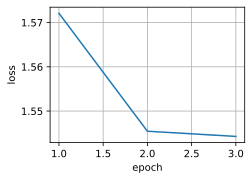

In [393]:
train_seq2seq(net, X_train, X_valid_len, Y_train, Y_valid_len, working_score_tensor, lr, num_epochs, batch_size, label_smoothing, amino_dict, device)

#### Model predicting

In [405]:
target = ['SPY', 'SPQ', 'SFILKSFR', 'LDLRNFYQ', 'FGAILSS', 'NVGGAVVTG']
num_steps_prediction = 10 # max length of sequence to predict

dec_comple_peptide_pred, dec_prob, dec_attention_weight_seq = predict_seq2seq(net, target[5], amino_dict, num_steps_prediction, device, save_attention_weights=True, print_info=True)

Conditional probability at position 1 is 0.09674233943223953
Conditional probability at position 2 is 0.09076384454965591
Conditional probability at position 3 is 0.0909266546368599
Conditional probability at position 4 is 0.09021279960870743
Conditional probability at position 5 is 0.0881866067647934
Conditional probability at position 6 is 0.099327951669693
Conditional probability at position 7 is 0.09581107646226883
Conditional probability at position 8 is 0.09100326150655746
Conditional probability at position 9 is 0.9157262444496155
Input target sequence is NVGGAVVTG, predicted complementary peptide is VVVVVVVV
Condition on input, predicted probability is 5.0373403154294215e-09


# Task 2: Train a base model 

#### Build base model

In [414]:
query_size, key_size, value_size, num_hiddens = 512, 512, 512, 512
num_layers, dropout = 4, 0.1
lr, num_epochs, batch_size, label_smoothing = 0.005, 100000, 64, 0.1
ffn_num_input, ffn_num_hiddens, num_heads = 512, 2048, 8

norm_shape = [512] # 32 corresponds to the dim of such number to normalize
device = try_gpu()

In [415]:
encoder_base = TransformerEncoder(
	len(amino_dict), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout)
decoder_base = TransformerDecoder(
	len(amino_dict), key_size, query_size, value_size, num_hiddens, 
	norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
	num_layers, dropout)
net_base = EncoderDecoder(encoder_base, decoder_base)

In [416]:
net_base_total_params = sum(p.numel() for p in net_base.parameters())
net_base_total_trainable_params = sum(p.numel() for p in net_base.parameters() if p.requires_grad)

print('Base model: total number of parameters: {}'.format(net_base_total_params))
print('Base model: total number of trainable parameters: {}'.format(net_base_total_trainable_params))

Base model: total number of parameters: 29437976
Base model: total number of trainable parameters: 29437976


#### Model training

In [412]:
# train_seq2seq(net_base, X_train, X_valid_len, Y_train, Y_valid_len, working_score_tensor, lr, num_epochs, batch_size, label_smoothing, amino_dict, device)

#### Model prediction

In [413]:
target = ['SPY', 'SPQ', 'SFILKSFR', 'LDLRNFYQ', 'FGAILSS', 'NVGGAVVTG']
num_steps_prediction = 10 # max length of sequence to predict

# dec_comple_peptide_pred, dec_prob, dec_attention_weight_seq = predict_seq2seq(net_base, target[5], amino_dict, num_steps_prediction, device, save_attention_weights=True, print_info=True)

#### Potential problems

1. Positional encoding failed to work in predict sequences------- fixed 
2. 'bos', 'eos' not trained? ------------------------------------ fixed 
3. Ramdomize each batch ----------------------------------------- fixed 
4. Softmax in prediction ---------------------------------------- fixed 
5. write functions for training-preposessing -------------------- fixed
6. write functions for prediction ------------------------------- fixed
7. label smoothing: alter learning truth distribution ----------- fixed 
8. weighting of each sample: sample weights in loss ------------- fixed
9. adjust learning rate ---------------------------------------- not changed since adam is insensitive to learning rate
10. loss shown too small ---------------------------------------- fixed 

#### Things to do

1. Assigne weights to each sample -------------------- done 
2. hyperparameter for base model training ------------ done 
3. train on imperial GPU
4. Write sampling sequence + prob function
5. Write functions for prob of pair sequences 
6. Consider anti para / para condition --------------- ignore this condition + ignore hb_pattern for now
7. save model parameters
8. check GPU availablity 
9. rewrite d2l functions